# An introduction to XGBoost
An ensemble is a group of models that aggregate results (in some ways) to prevent overfitting. The ensembling technique used by XGBoost (or eXtreme Gradient BOOSting) is called _boosting_. 

Boosting is a type of ensemble learning technique that combines multiple weak learners to form a strong learner. A weak learner is a model that performs only slightly better than random guessing. In the case of XGBoost, the weak learners are decision trees; and a week tree is a shallow tree. Using
many shallower trees tends to provide better performance and quicker results. One reason for that is because shallow trees are less prone to overfitting than deep trees.

The idea behind boosting is to iteratively train weak learners, with each iteration focusing on the examples that were misclassified by the previous weak learner. The predictions of all the weak learners are then combined through a weighted majority vote to produce the final prediction.

In XGBoost, this is done using _gradient boosting_. Gradient boosting is an approach where new models are created that predict the _residuals_ (the true value minus the predicted
value) of prior models and then added together to make the final prediction. This process is repeated until no further improvements can be made. 

In regression problems, when the residuals have positive values it means our predicted values have a higher value than the value we are trying to predict and conversely, when the values are negative, our predicted values are lower.

In classification tasks, the goal is to predict a label for a given data point. The model outputs a probability for each possible label, representing how likely it thinks that label is to be the correct one. or example, let’s say we have a binary classification problem where we are trying to predict whether an email is spam or not. A perfect model would output a probability of 1 for the correct label and 0 for the incorrect label. So if an email is actually spam, a perfect model would output a probability of 1 for the “spam” label and 0 for the “not spam” label.

In this case, we can think of the residual as the difference between the perfect probability (1) and the predicted probability. So if our model predicted a probability of 0.4 for the “spam” label, the residual would be 0.6 (1 - 0.4). This means that our model’s prediction was too low by 0.6. In gradient boosting, subsequent rounds of boosting try to correct these residuals by predicting them directly. So in our example, the next round of boosting would try to predict a value of 0.6 to correct our model’s initial prediction.

One benefit of using XGBoost is that it has built-in support for handling missing values. This means that you don’t have to worry about imputing missing values in your data before feeding it into the model. XGBoost will automatically handle missing values in a way that is optimized for the specific problem you are trying to solve.

Another benefit of using XGBoost is that it has support for learning from categorical features. Categorical features are variables that can take on one of a limited number of possible values, such as “red,” “green,” or “blue.” XGBoost can automatically encode these categorical features in a way that is suitable for use in the model.

In addition to these benefits, XGBoost also provides various hyperparameters that can be tuned to control the behavior of the model and prevent overfitting. Overfitting occurs when a model is too complex and fits the training data too closely, including its noise and random fluctuations. By tuning the hyperparameters of the XGBoost model, you can control its complexity and reduce the risk of overfitting.

In summary, XGBoost builds an ensemble of decision trees in an iterative manner, where each new tree tries to correct the mistakes of the previous trees. The final prediction is made by combining the predictions of all the trees.

## 9.4 Creating an XGBoost Mode

In [1]:
import dtreeviz
from feature_engine import encoding, imputation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import base, compose, datasets, ensemble, metrics, model_selection, pipeline, preprocessing, tree
import scikitplot
import xgboost as xgb
import yellowbrick.model_selection as ms
from yellowbrick import classifier
import urllib
import zipfile

from EffectiveXGBoost import *

In [2]:
path_url = 'https://github.com/mattharrison/datasets/raw/master/data/kaggle-survey-2018.zip'
file_name = 'kaggle-survey-2018.zip'
dataset = 'multipleChoiceResponses.csv'

raw = extract_dataset(path_url, file_name, dataset)

G:\My Drive\SisengAI\AlgorithmicTrading\code_rebuilding\MattHarrison\EffectiveXGBoost\EffectiveXGBoost_MyTake\EffectiveXGBoost.py:56: DtypeWarning: Columns (0,2,8,10,21,23,24,25,26,27,28,44,56,64,83,85,87,107,109,123,125,150,157,172,174,194,210,218,219,223,246,249,262,264,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,304,306,325,326,329,341,368,371,384,385,389,390,391,393,394) have mixed types. Specify dtype option on import or set low_memory=False.


In [3]:
# Create raw X and raw y
kag_X, kag_y = prepX_y(raw, 'Q6')

In [4]:
# Split data
kag_X_train, kag_X_test, kag_y_train, kag_y_test = (model_selection
                                                    .train_test_split(kag_X, 
                                                                      kag_y, 
                                                                      test_size=.3, 
                                                                      random_state=42, 
                                                                      stratify=kag_y)
                                                   )


In [5]:
# Transform X with pipeline
pline = pipeline.Pipeline(
    [('tweak', PrepDataTransformer()),
    ('cat', encoding.OneHotEncoder(top_categories=5, drop_last=True,
    variables=['Q1', 'Q3', 'major'])),
    ('num_impute', imputation.MeanMedianImputer(imputation_method='median',
                variables=['education', 'years_exp']))]
    )

X_train = pline.fit_transform(kag_X_train)
X_test =pline.transform(kag_X_test)

In [6]:
# Transform y with label encoder
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(kag_y_train)
y_train = label_encoder.transform(kag_y_train)
y_test = label_encoder.transform(kag_y_test)

In [7]:
# Combined Data for cross validation/etc
X = pd.concat([X_train, X_test], axis='index')
y = pd.Series([*y_train, *y_test], index=X.index)

We have our training data and test data and are ready to create models.

## 9.5 A Boosted Model

* First is to create an instance of the model,
* Next we call the `.fit` method to train the model on the training data.
* Then we evaluate the model using the `.score` method, which tells us the accuracy of the model.

In [8]:
xg_oob = xgb.XGBClassifier()
xg_oob.fit(X_train, y_train)
xg_oob.score(X_test, y_test)

0.7458563535911602

Out of the box, the default model performs 100 rounds of boosting and the accuracy of the boosted model (.745) is quite a bit better than both
a decision tree (.73 for a depth of 7) and a random forest (.72 from scikit-learn).

In [9]:
 # Let's try w/ depth of 2 and 2 trees
xg2 = xgb.XGBClassifier(max_depth=2, n_estimators=2)
xg2.fit(X_train, y_train)
xg2.score(X_test, y_test)

0.6685082872928176

Tweaking the hyperparameters can have a large impact on our model’s performance. As we can see, our performance dropped quite a bit.
Let’s look at what the first tree looks like with the dtreeviz package and use `tree_index=0` to indicate this.

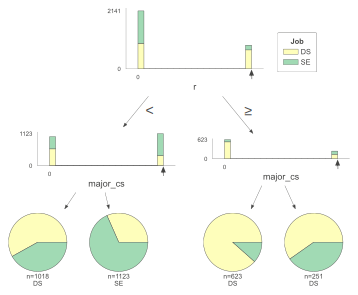

In [10]:
import dtreeviz
viz = dtreeviz.model(xg2, X_train=X, y_train=y, target_name='Job',
feature_names=list(X_train.columns),
class_names=['DS', 'SE'], tree_index=0)
viz.view(depth_range_to_display=[0,2])

From what we can see above, it seems to first consider whether the user uses
the R programming language. Then it looks at whether the user studied CS. 

## 9.6 Understanding the Output of the Trees

Unfortunately, the `dtreeviz` library does not show with XGBoost models is the score for the nodes.
Let’s use XGBoost to plot the same booster (using num_trees=0) and trace through an
example to understand the leaf scores.

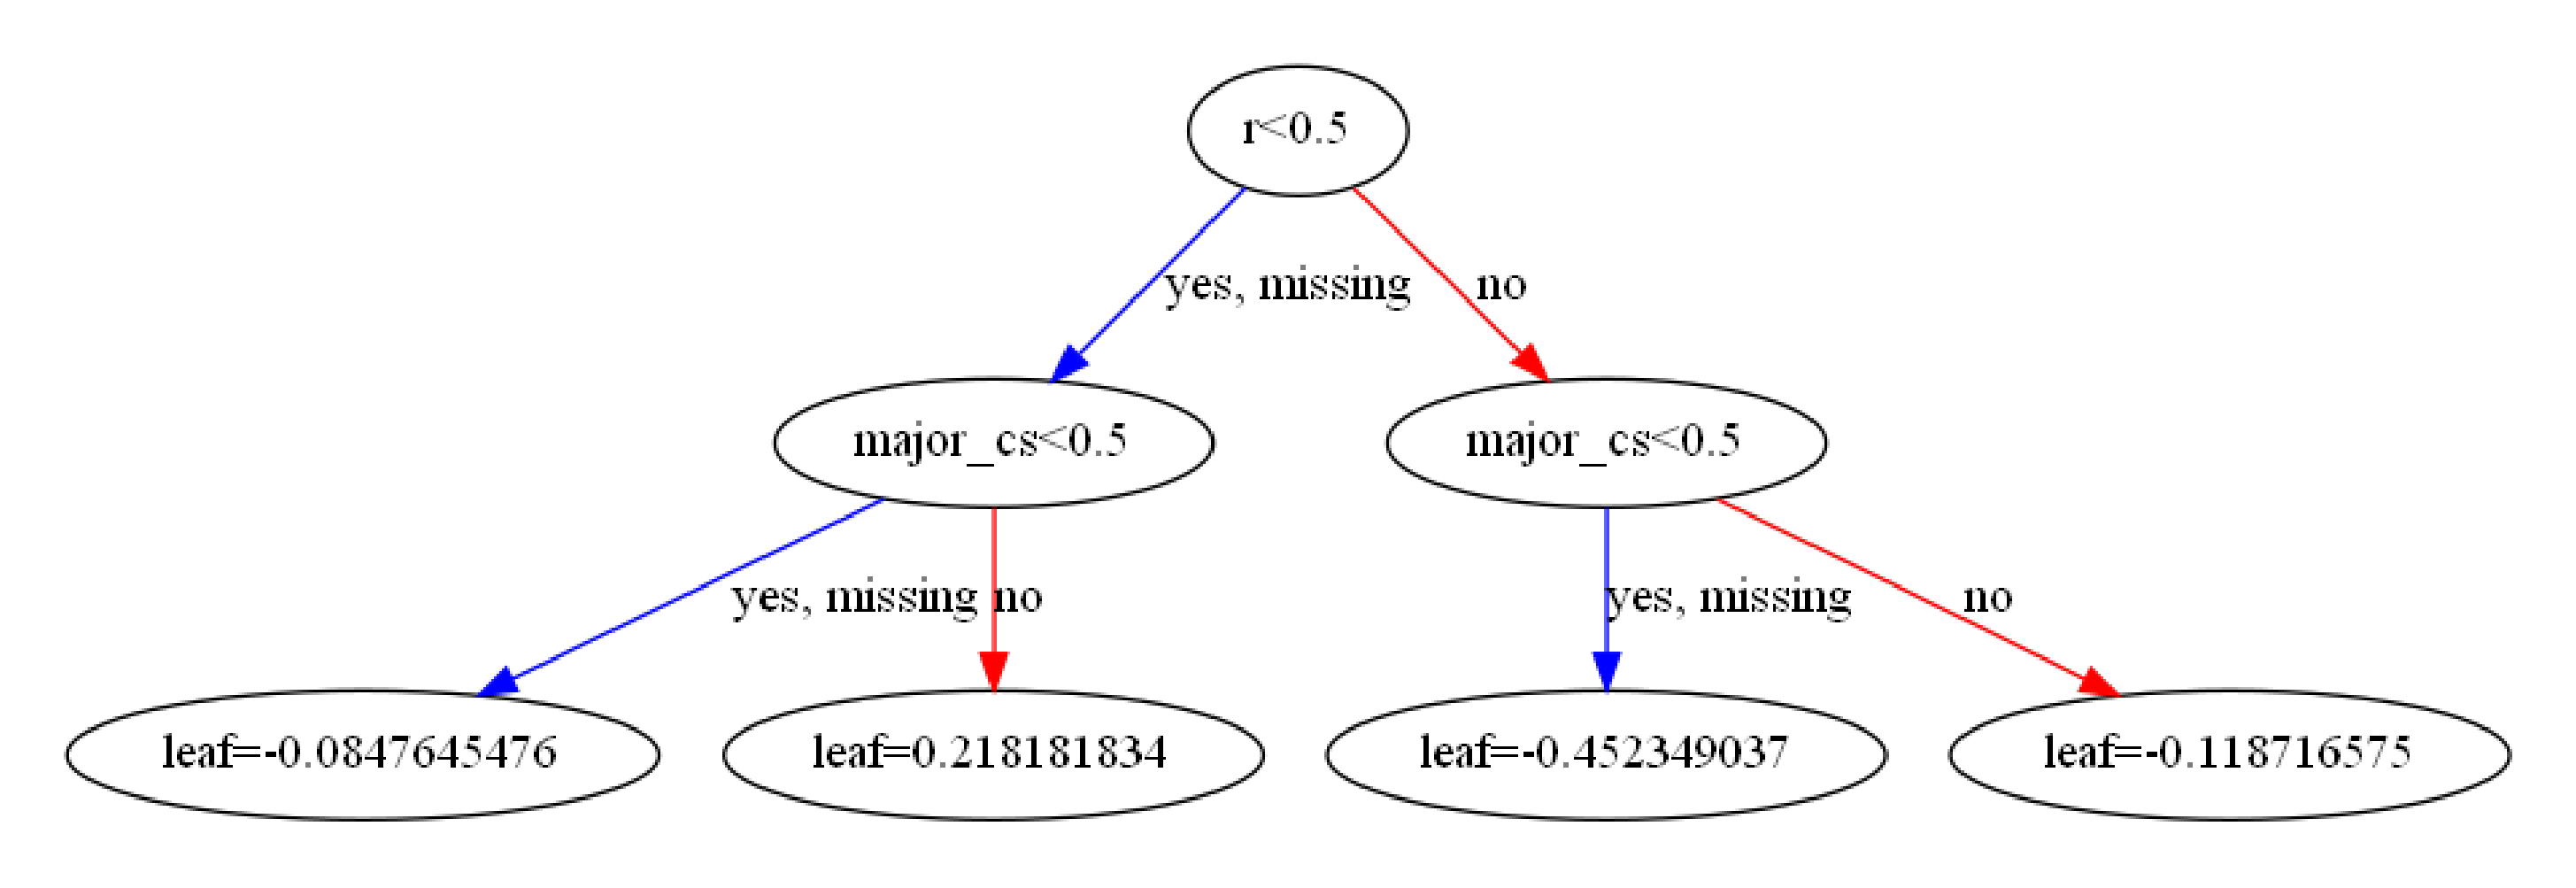

In [17]:
fig, ax = plt.subplots(figsize=(6,12), dpi=600)
_=xgb.plot_tree(xg2, num_trees=0, ax=ax)

my_dot_export(xg2, n_trees=0, filename='img/xgb_md2.dot', title='First Tree')

In [14]:
my_dot_export(xg2, n_trees=0, filename='img/xgb_md2.dot', title='First Tree')

Here is the prediction for this two-tree model. It predicts 49.8% data scientist and 50.1%
software engineer. Because 50.1% is greater than 50%, our model predicts 1 or software
engineer for this example.
We can ask the model to predict probabilities with `.predict_proba`.

In [18]:
# Predicts 1 - Software engineer
se1116 = pd.DataFrame({'age': {7894: 22},
 'education': {7894: 16.0},
 'years_exp': {7894: 1.0},
 'compensation': {7894: 0},
 'python': {7894: 1},
'r': {7894: 0},
'sql': {7894: 0},
 'Q1_Male': {7894: 1},
 'Q1_Female': {7894: 0},
 'Q1_Prefer not to say': {7894: 0},
 'Q1_Prefer to self-describe': {7894: 0},
 'Q3_United States of America': {7894: 0},
 'Q3_India': {7894: 1},
 'Q3_China': {7894: 0},
 'major_cs': {7894: 0},
 'major_other': {7894: 0},
 'major_eng': {7894: 0},
 'major_stat': {7894: 0}})
xg2.predict_proba(se1116)

array([[0.4986236, 0.5013764]], dtype=float32)

Or we can predict just the value with `.predict`:

In [19]:
# Predicts 1 - Software engineer
xg2.predict(pd.DataFrame(se1116))

array([1])

The `.predict` method returns the predicted class label for each input data point. 

The `.predict_proba` method returns the predicted probabilities for each class label. Instead of returning a single predicted label for each input data point, it returns an array of probabilities representing how likely the model thinks each possible label is. 

For our example, the user did not use R, so we took a left turn at the first node. They did
not study CS, so we moved left at that node and ended with a leaf value of -0.084.
Now let’s trace what happens in the second tree.
First, let’s plot it. Remember that this tree tries to fix the predictions of the tree before it.
(We specify num_trees=1 for the second tree because Python is zero-based.)

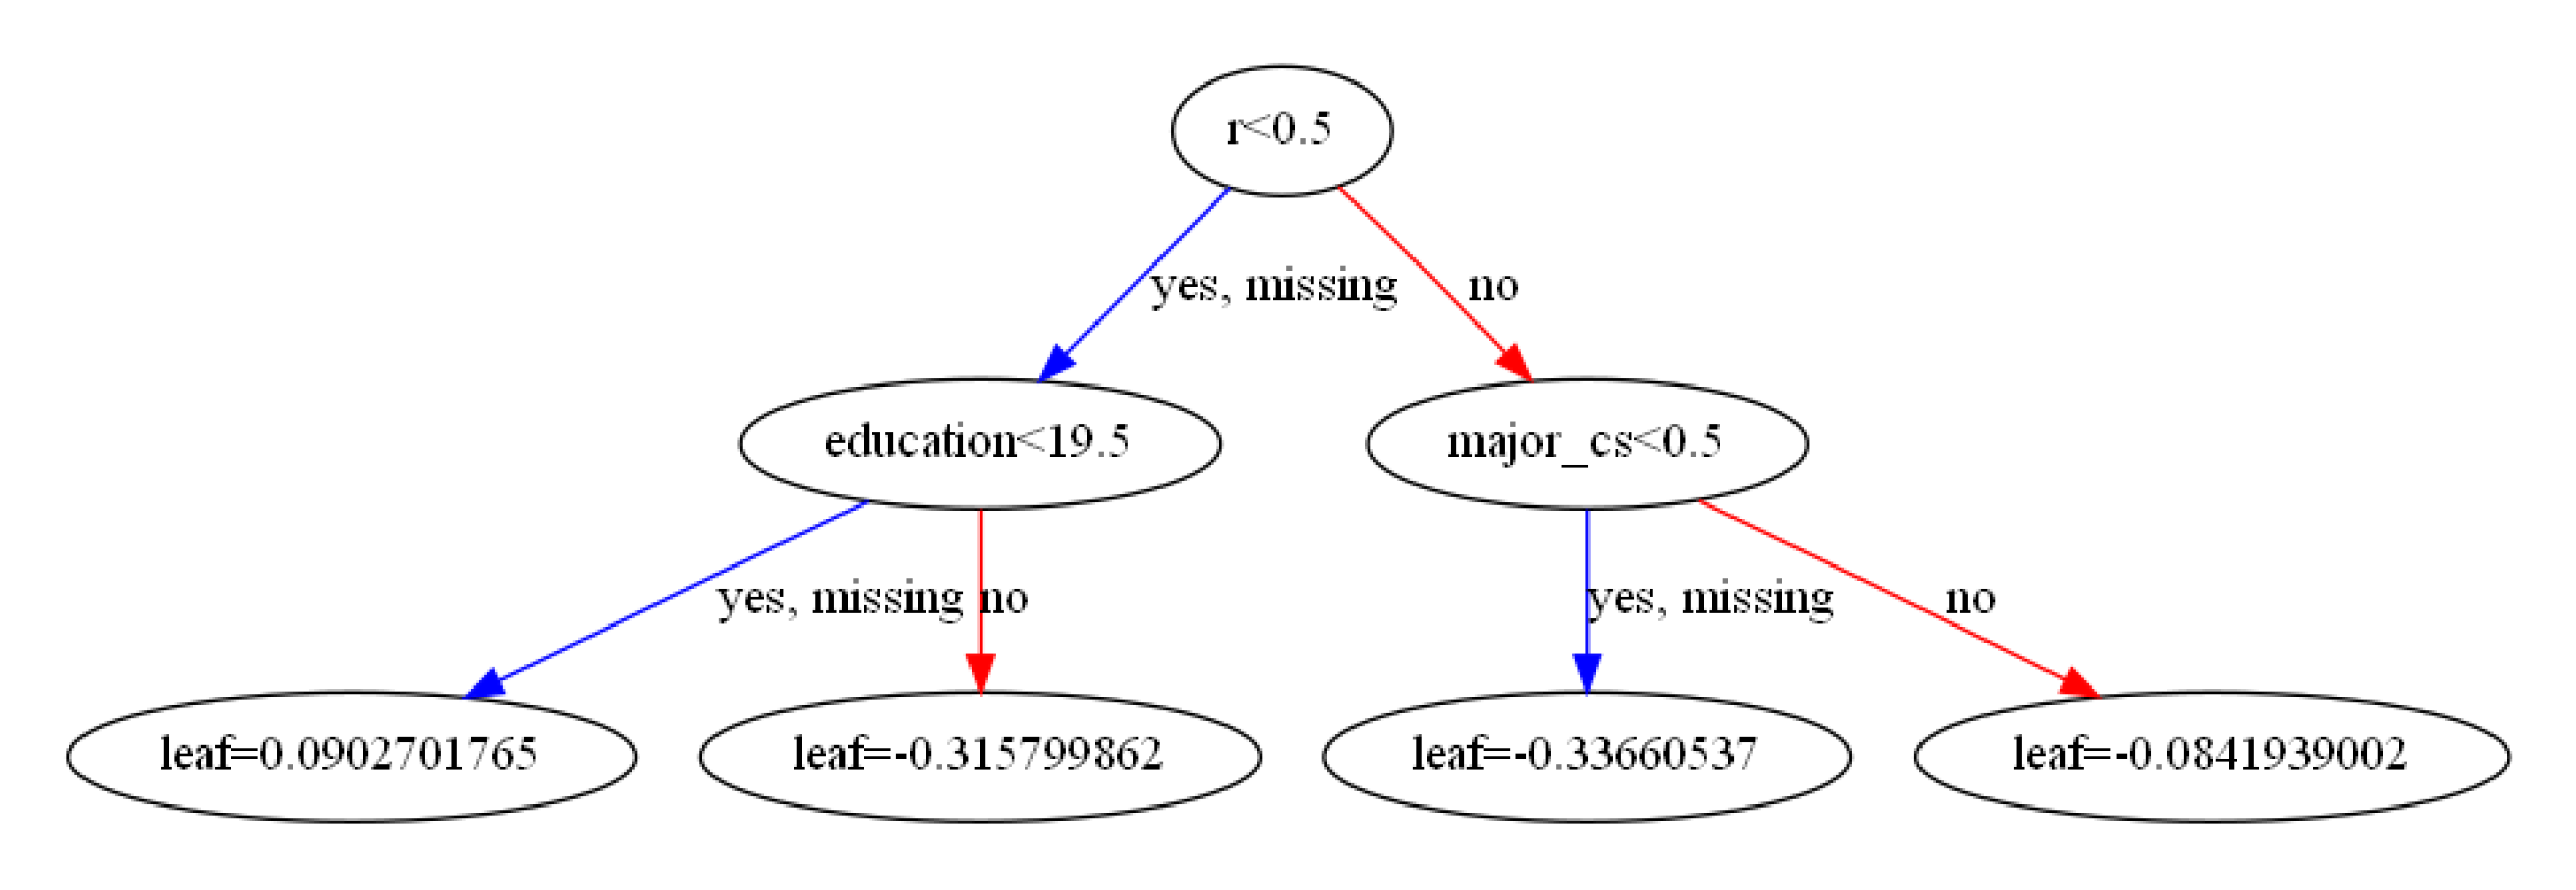

In [20]:
fig, ax = plt.subplots(figsize=(6,12), dpi=600)
_=xgb.plot_tree(xg2, num_trees=1, ax=ax)

my_dot_export(xg2, n_trees=1, filename='img/xgb_md2_tree1.dot', title='Second Tree')

Again, our example does not use R, so we go left on the first node. The education level is
16, so we take another left at the next node and end at a value of 0.0902.
Our prediction is made by adding these leaf values together and taking the inverse logit
of the sum. This returns the probability of the positive class.

In [22]:
def inv_logit(p):
    return np.exp(p) / (1 + np.exp(p))

inv_logit(-0.08476+0.0902701)

0.5013775215147345

We calculate the inverse logit of the sum of the leaf values and come up with .501. Again
this corresponds to 50.1% software engineer (with binary classifiers, this is the percent that
the label is 1, or software engineer).
If there were more trees, we would repeat this process and add up the values in the leaves.
Note that due to the inverse logistic function, values above 0 push towards the positive label,
and values below zero push to the negative label.
